# Pressure Sensor Data Analysis: ADC Values

This Jupyter Notebook provides a comprehensive analysis of ADC (Analog-to-Digital Converter) values collected from pressure sensors. The goal is to extract meaningful insights from the raw and cleaned sensor data, focusing on the impact of different weights, sensor types, and the presence or absence of a 'lump' on the sensor readings. We will perform statistical analysis and generate a variety of visualizations to understand the data distribution, trends, and differences across experimental conditions.

## 1. Setup and Data Loading

First, we'll import the necessary libraries and define functions to load and parse the cleaned ADC data files. The filenames contain crucial metadata such as weight, sensor type, lump status, and trial number, which will be extracted for analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import glob

# Configure seaborn for better aesthetics
sns.set_theme(style="whitegrid", palette="viridis")
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12

def parse_filename(filepath):
    """Parses the filename to extract metadata."""
    basename = os.path.basename(filepath)
    # Example filename: clean_ADC_2159.64g_B_trial1_LUMP_raw_20250702_144837.csv
    match = re.match(r'clean_ADC_([\d\.]+)g_([A-Z])_trial(\d+)_(NO_)?(LUMP)_raw_.*\.csv', basename)
    if match:
        weight = float(match.group(1))
        sensor = match.group(2)
        trial = int(match.group(3))
        lump_status = 'NO_LUMP' if match.group(4) else 'LUMP'
        return {'weight': weight, 'sensor': sensor, 'trial': trial, 'lump_status': lump_status}
    
    # Handle base ADC file: clean_ADC_raw_20250702_144745.csv
    match_base = re.match(r'clean_ADC_raw_.*\.csv', basename)
    if match_base:
        return {'weight': 0.0, 'sensor': 'Unknown', 'trial': 0, 'lump_status': 'Unknown'}
    
    return None

all_cleaned_files = glob.glob('hta/**/clean_ADC_*.csv', recursive=True)
print(f"Found {len(all_cleaned_files)} cleaned ADC files.")

data_records = []
for fpath in all_cleaned_files:
    metadata = parse_filename(fpath)
    if metadata:
        try:
            df_adc = pd.read_csv(fpath)
            if 'ADC' in df_adc.columns:
                metadata['mean_adc'] = df_adc['ADC'].mean()
                metadata['std_dev_adc'] = df_adc['ADC'].std()
                metadata['min_adc'] = df_adc['ADC'].min()
                metadata['max_adc'] = df_adc['ADC'].max()
                metadata['count_adc'] = df_adc['ADC'].count()
                metadata['file_path'] = fpath
                metadata['raw_data'] = df_adc['ADC'].tolist() # Store raw data for plotting
                data_records.append(metadata)
            else:
                print(f"Warning: 'ADC' column not found in {fpath}")
        except Exception as e:
            print(f"Error reading {fpath}: {e}")

df_summary = pd.DataFrame(data_records)

print("Summary of Loaded Data:")
print(df_summary.head(50))
print("Data Info:")
df_summary.info()
print("Descriptive Statistics:")
print(df_summary.describe())


Found 25 cleaned ADC files.
Summary of Loaded Data:
     weight sensor  trial lump_status     mean_adc  std_dev_adc  min_adc  \
0   2159.64      B      1        LUMP  3214.323741     0.809507     3212   
1   2159.64      D      1     NO_LUMP  2612.086331     2.698583     2607   
2    847.23      D      1        LUMP  2823.071942     2.076927     2819   
3   2159.64      B      1     NO_LUMP  2945.503597     1.138102     2943   
4   2159.64      D      2     NO_LUMP  2825.870504     1.463738     2822   
5    847.23      B      1        LUMP  2805.251799     2.000339     2802   
6   2159.64      B      3     NO_LUMP  2896.158273     1.137369     2894   
7   2159.64      D      1        LUMP  3097.467626     4.934795     3090   
8   2159.64      B      2     NO_LUMP  2906.647482     2.049614     2903   
9   2159.64      D      3     NO_LUMP  2834.683453     5.287442     2830   
10  2159.64      D      3        LUMP  3129.273381     0.749935     3128   
11   847.23      B      1     NO_LUM

## 2. Detailed Statistical Analysis

Now, let's delve deeper into the statistics, grouping the data by sensor, weight, and lump status to observe patterns and differences.

In [12]:
grouped_stats = df_summary.groupby(['sensor', 'weight', 'lump_status']).agg(
    avg_mean_adc=('mean_adc', 'mean'),
    std_mean_adc=('mean_adc', 'std'),
    avg_std_dev_adc=('std_dev_adc', 'mean'),
    std_std_dev_adc=('std_dev_adc', 'std'),
    min_overall_adc=('min_adc', 'min'),
    max_overall_adc=('max_adc', 'max'),
    num_trials=('trial', 'count')
).reset_index()

print("Grouped Statistics (Average of Means and Std Devs across trials):")
print(grouped_stats.sort_values(by=['sensor', 'weight', 'lump_status']))

# Further grouping by sensor type
sensor_stats = df_summary.groupby('sensor').agg(
    overall_mean_adc=('mean_adc', 'mean'),
    overall_std_dev_adc=('std_dev_adc', 'mean'),
    total_readings=('count_adc', 'sum')
).reset_index()

print("Statistics by Sensor Type:")
print(sensor_stats.sort_values(by='sensor'))


Grouped Statistics (Average of Means and Std Devs across trials):
  sensor   weight lump_status  avg_mean_adc  std_mean_adc  avg_std_dev_adc  \
0      B   847.23        LUMP   2863.062350     50.463651         1.880571   
1      B   847.23     NO_LUMP   2710.357314     12.591910         3.079604   
2      B  2159.64        LUMP   3209.316547      4.472113         0.757339   
3      B  2159.64     NO_LUMP   2916.103118     25.996096         1.441695   
4      D   847.23        LUMP   2844.426859     19.243915         1.921313   
5      D   847.23     NO_LUMP   2369.708633     13.496074         2.310657   
6      D  2159.64        LUMP   3116.494005     16.797925         2.156018   
7      D  2159.64     NO_LUMP   2757.546763    126.049474         3.149921   

   std_std_dev_adc  min_overall_adc  max_overall_adc  num_trials  
0         0.158994             2802             2901           3  
1         2.466277             2698             2733           3  
2         0.054458            

## 3. Comprehensive Visualizations

This section will generate a variety of plots to visually explore the data. We'll start with overall distributions and then move to more specific comparisons.

### 3.1 Overall Distribution of Mean ADC Values

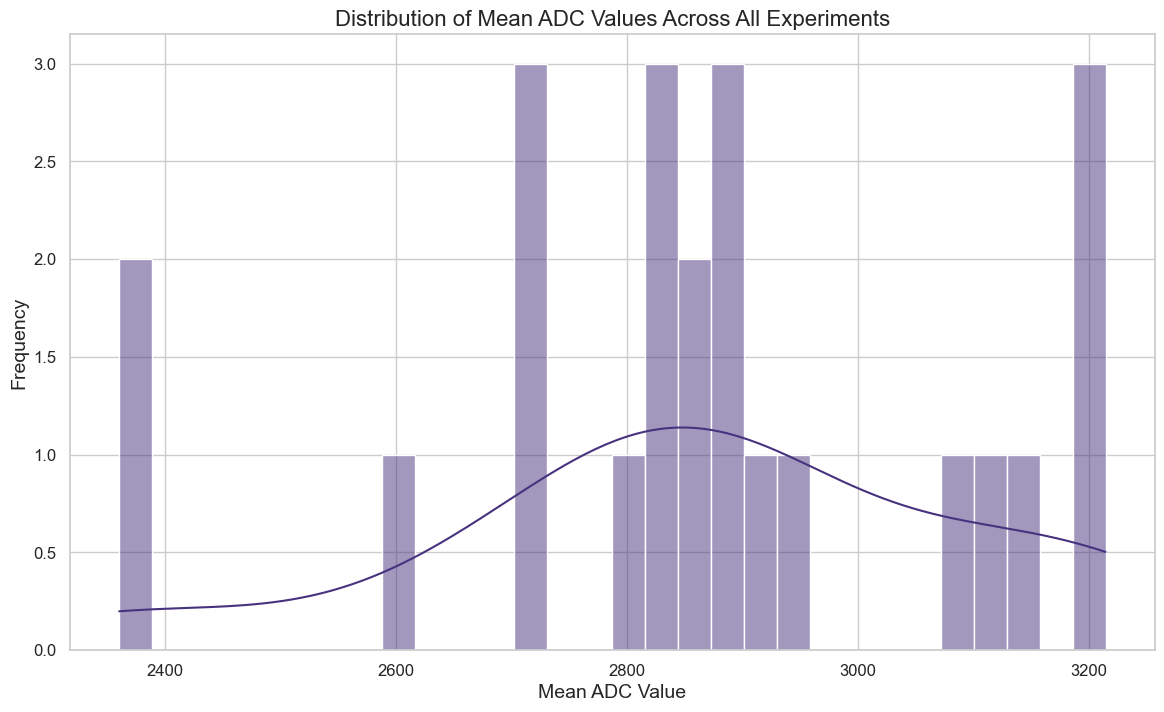

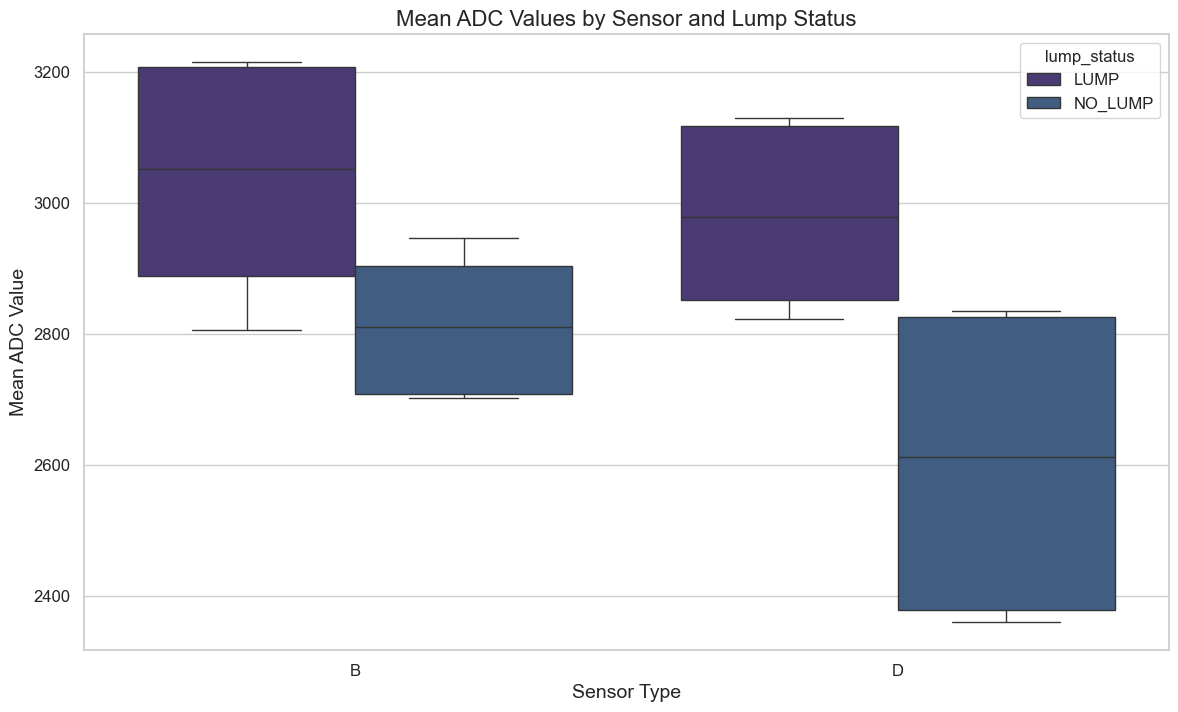

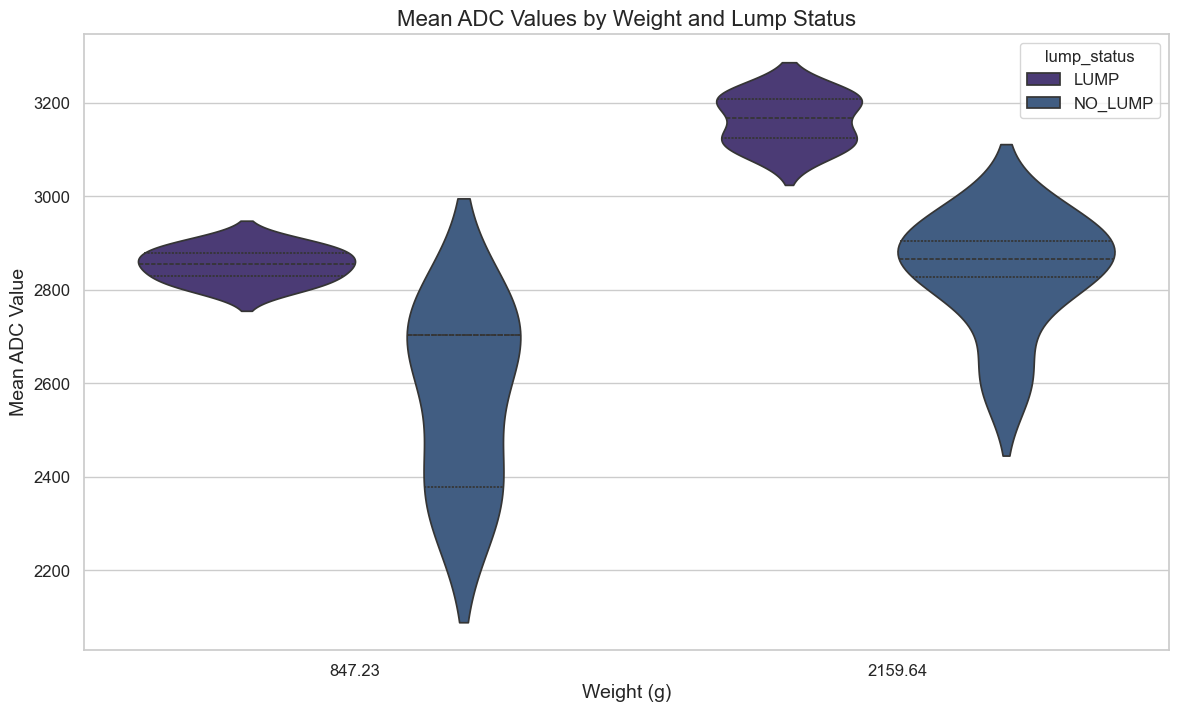

In [13]:
plt.figure(figsize=(14, 8))
sns.histplot(df_summary['mean_adc'], kde=True, bins=30)
plt.title('Distribution of Mean ADC Values Across All Experiments')
plt.xlabel('Mean ADC Value')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(14, 8))
sns.boxplot(x='sensor', y='mean_adc', hue='lump_status', data=df_summary)
plt.title('Mean ADC Values by Sensor and Lump Status')
plt.xlabel('Sensor Type')
plt.ylabel('Mean ADC Value')
plt.show()

plt.figure(figsize=(14, 8))
sns.violinplot(x='weight', y='mean_adc', hue='lump_status', data=df_summary, inner='quartile')
plt.title('Mean ADC Values by Weight and Lump Status')
plt.xlabel('Weight (g)')
plt.ylabel('Mean ADC Value')
plt.show()


### 3.2 ADC Values Across Trials for a Given Sensor and Weight

This visualization helps assess the consistency of readings across multiple trials under the same conditions.

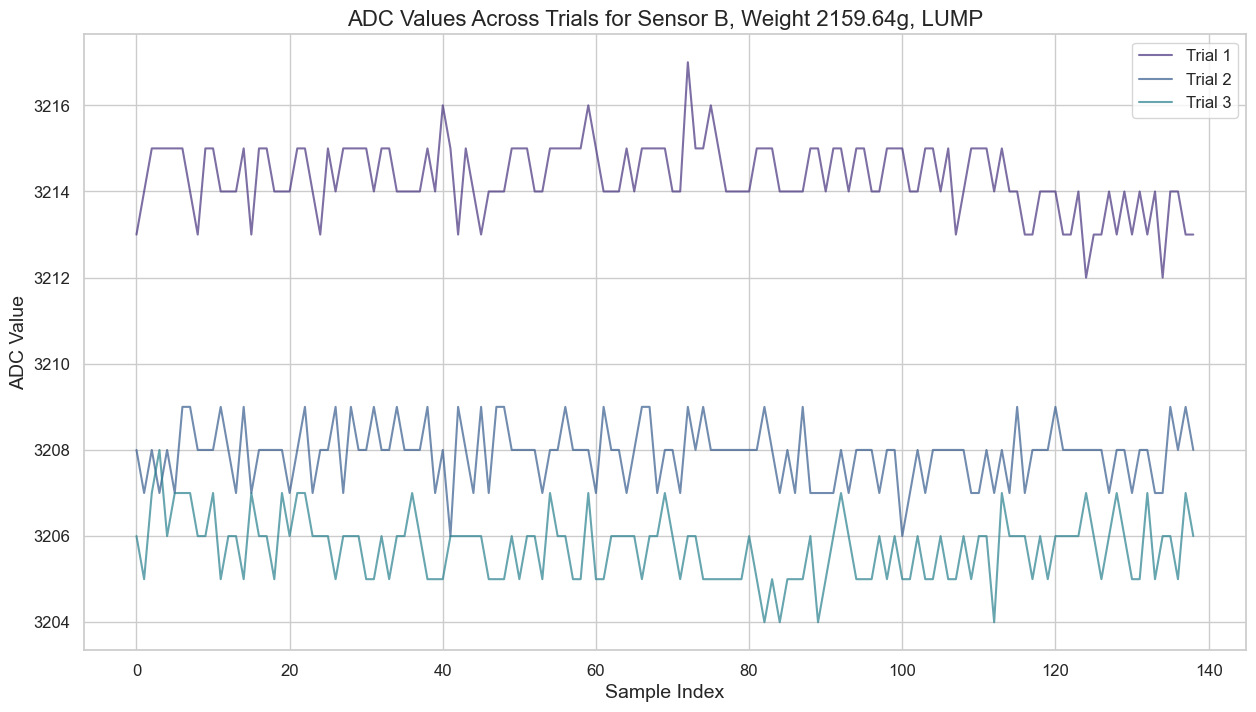

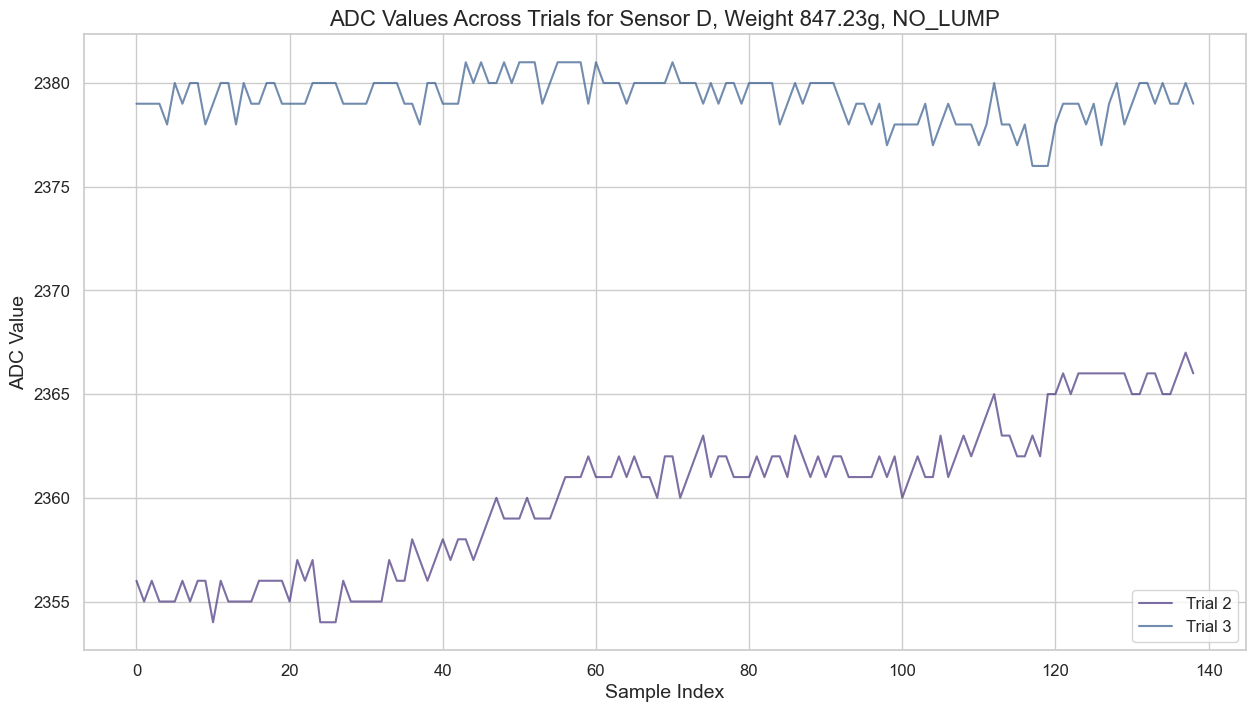

In [14]:
# Example: Sensor B, Weight 2159.64g, LUMP
sensor_to_plot = 'B'
weight_to_plot = 2159.64
lump_status_to_plot = 'LUMP'

subset_data = df_summary[
    (df_summary['sensor'] == sensor_to_plot) &
    (df_summary['weight'] == weight_to_plot) &
    (df_summary['lump_status'] == lump_status_to_plot)
].sort_values(by='trial')

if not subset_data.empty:
    plt.figure(figsize=(15, 8))
    for index, row in subset_data.iterrows():
        plt.plot(row['raw_data'], label=f"Trial {row['trial']}", alpha=0.7)
    plt.title(f'ADC Values Across Trials for Sensor {sensor_to_plot}, Weight {weight_to_plot}g, {lump_status_to_plot}')
    plt.xlabel('Sample Index')
    plt.ylabel('ADC Value')
    plt.legend()
    plt.show()
else:
    print(f"No data found for Sensor {sensor_to_plot}, Weight {weight_to_plot}g, {lump_status_to_plot}")

# Example: Sensor D, Weight 847.23g, NO_LUMP
sensor_to_plot = 'D'
weight_to_plot = 847.23
lump_status_to_plot = 'NO_LUMP'

subset_data = df_summary[
    (df_summary['sensor'] == sensor_to_plot) &
    (df_summary['weight'] == weight_to_plot) &
    (df_summary['lump_status'] == lump_status_to_plot)
].sort_values(by='trial')

if not subset_data.empty:
    plt.figure(figsize=(15, 8))
    for index, row in subset_data.iterrows():
        plt.plot(row['raw_data'], label=f"Trial {row['trial']}", alpha=0.7)
    plt.title(f'ADC Values Across Trials for Sensor {sensor_to_plot}, Weight {weight_to_plot}g, {lump_status_to_plot}')
    plt.xlabel('Sample Index')
    plt.ylabel('ADC Value')
    plt.legend()
    plt.show()
else:
    print(f"No data found for Sensor {sensor_to_plot}, Weight {weight_to_plot}g, {lump_status_to_plot}")


### 3.3 ADC Values Across Different Weights for a Given Sensor and Lump Status

This plot helps visualize how ADC readings change with varying applied weights for a specific sensor and lump condition.

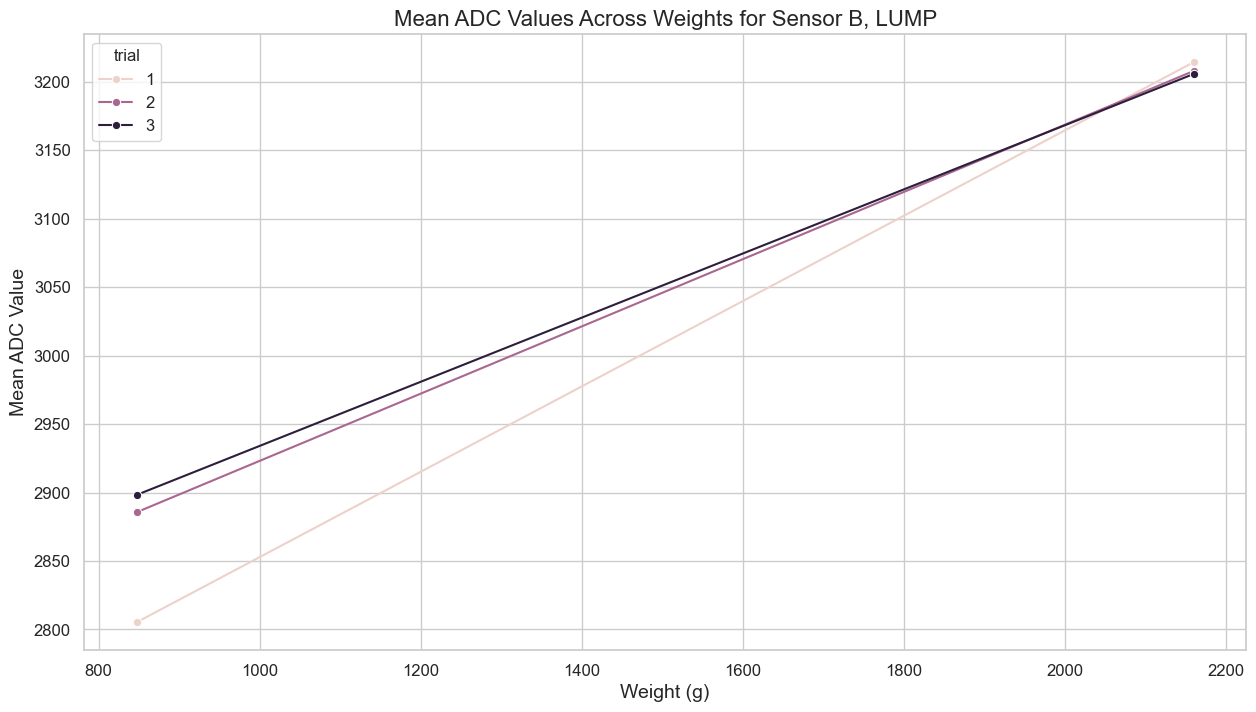

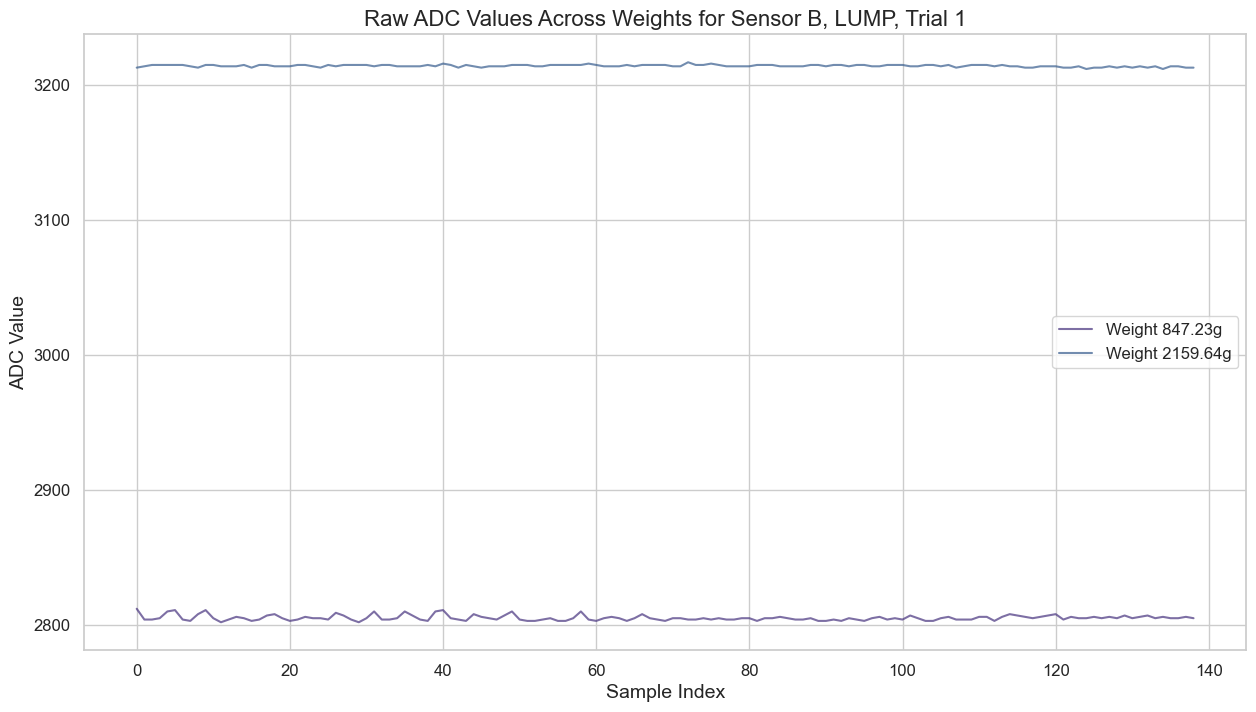

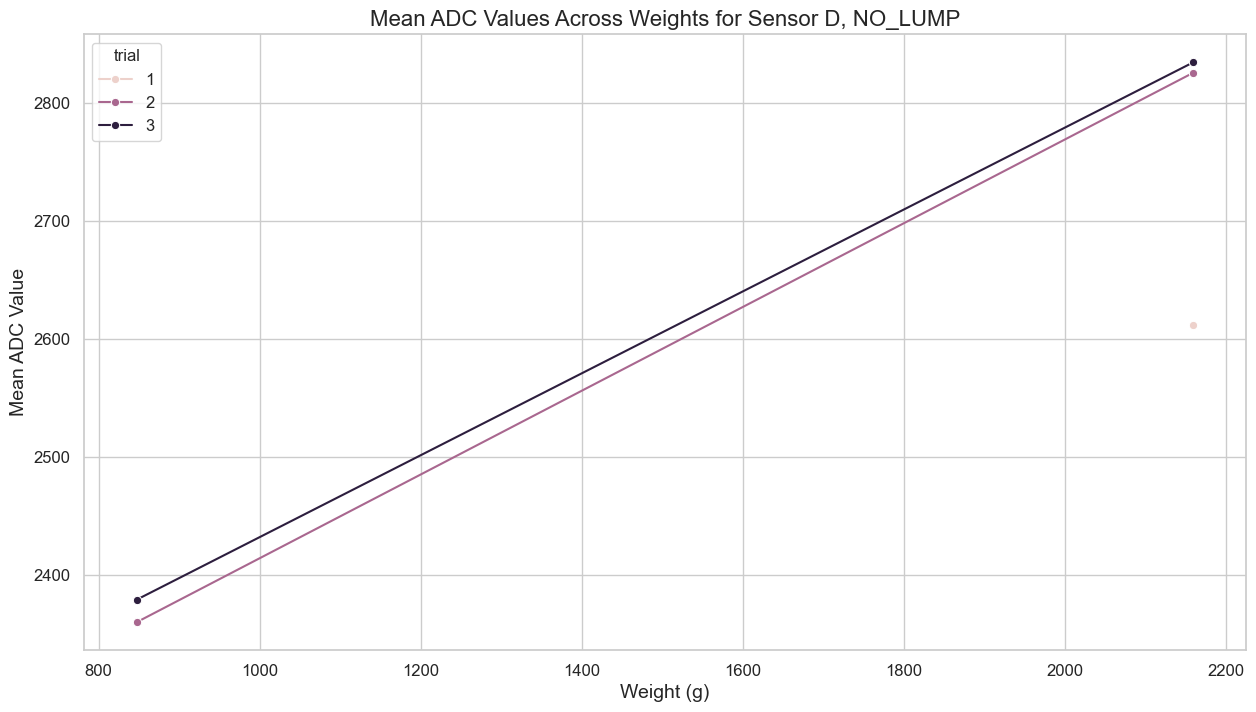

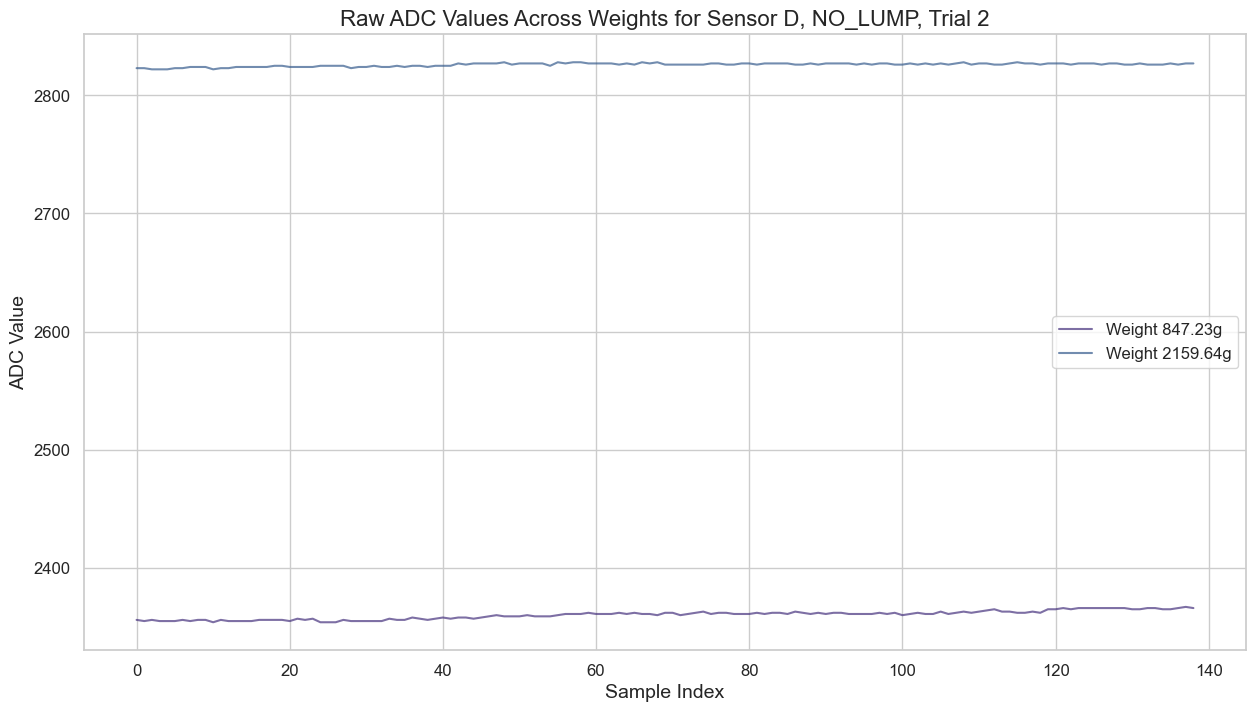

In [15]:
# Example: Sensor B, LUMP, Trial 1 (or average across trials)
sensor_to_plot = 'B'
lump_status_to_plot = 'LUMP'

subset_data = df_summary[
    (df_summary['sensor'] == sensor_to_plot) &
    (df_summary['lump_status'] == lump_status_to_plot)
].sort_values(by='weight')

if not subset_data.empty:
    plt.figure(figsize=(15, 8))
    # Plot mean ADC values for each weight
    sns.lineplot(x='weight', y='mean_adc', hue='trial', data=subset_data, marker='o')
    plt.title(f'Mean ADC Values Across Weights for Sensor {sensor_to_plot}, {lump_status_to_plot}')
    plt.xlabel('Weight (g)')
    plt.ylabel('Mean ADC Value')
    plt.show()

    # Plot raw data for a specific trial (e.g., trial 1) across weights
    trial_to_plot = 1 # Assuming trial 1 exists for all weights
    subset_raw_data = subset_data[subset_data['trial'] == trial_to_plot]
    if not subset_raw_data.empty:
        plt.figure(figsize=(15, 8))
        for index, row in subset_raw_data.iterrows():
            plt.plot(row['raw_data'], label=f"Weight {row['weight']}g", alpha=0.7)
        plt.title(f'Raw ADC Values Across Weights for Sensor {sensor_to_plot}, {lump_status_to_plot}, Trial {trial_to_plot}')
        plt.xlabel('Sample Index')
        plt.ylabel('ADC Value')
        plt.legend()
        plt.show()
    else:
        print(f"No raw data for trial {trial_to_plot} found for Sensor {sensor_to_plot}, {lump_status_to_plot}")
else:
    print(f"No data found for Sensor {sensor_to_plot}, {lump_status_to_plot}")

# Example: Sensor D, NO_LUMP, Trial 2
sensor_to_plot = 'D'
lump_status_to_plot = 'NO_LUMP'

subset_data = df_summary[
    (df_summary['sensor'] == sensor_to_plot) &
    (df_summary['lump_status'] == lump_status_to_plot)
].sort_values(by='weight')

if not subset_data.empty:
    plt.figure(figsize=(15, 8))
    sns.lineplot(x='weight', y='mean_adc', hue='trial', data=subset_data, marker='o')
    plt.title(f'Mean ADC Values Across Weights for Sensor {sensor_to_plot}, {lump_status_to_plot}')
    plt.xlabel('Weight (g)')
    plt.ylabel('Mean ADC Value')
    plt.show()

    trial_to_plot = 2
    subset_raw_data = subset_data[subset_data['trial'] == trial_to_plot]
    if not subset_raw_data.empty:
        plt.figure(figsize=(15, 8))
        for index, row in subset_raw_data.iterrows():
            plt.plot(row['raw_data'], label=f"Weight {row['weight']}g", alpha=0.7)
        plt.title(f'Raw ADC Values Across Weights for Sensor {sensor_to_plot}, {lump_status_to_plot}, Trial {trial_to_plot}')
        plt.xlabel('Sample Index')
        plt.ylabel('ADC Value')
        plt.legend()
        plt.show()
    else:
        print(f"No raw data for trial {trial_to_plot} found for Sensor {sensor_to_plot}, {lump_status_to_plot}")
else:
    print(f"No data found for Sensor {sensor_to_plot}, {lump_status_to_plot}")


### 3.4 Delta Analysis: Lump vs. No Lump

This section focuses on quantifying the difference in ADC readings when a 'lump' is present versus when it's not, for the same sensor and applied weight. This is crucial for understanding the sensor's response to localized pressure.

Delta (LUMP - NO_LUMP) Mean ADC Values:
  sensor   weight  trial  delta_mean_adc
0      B   847.23      1       80.366906
1      B   847.23      2      182.028777
2      B   847.23      3      195.719424
3      B  2159.64      1      268.820144
4      B  2159.64      2      301.258993


/var/folders/39/vp90gr214c13m_vlt2mvyqz80000gn/T/ipykernel_75585/3018978519.py:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(x='weight', y='delta_mean_adc', hue='sensor', data=df_delta, ci='sd')


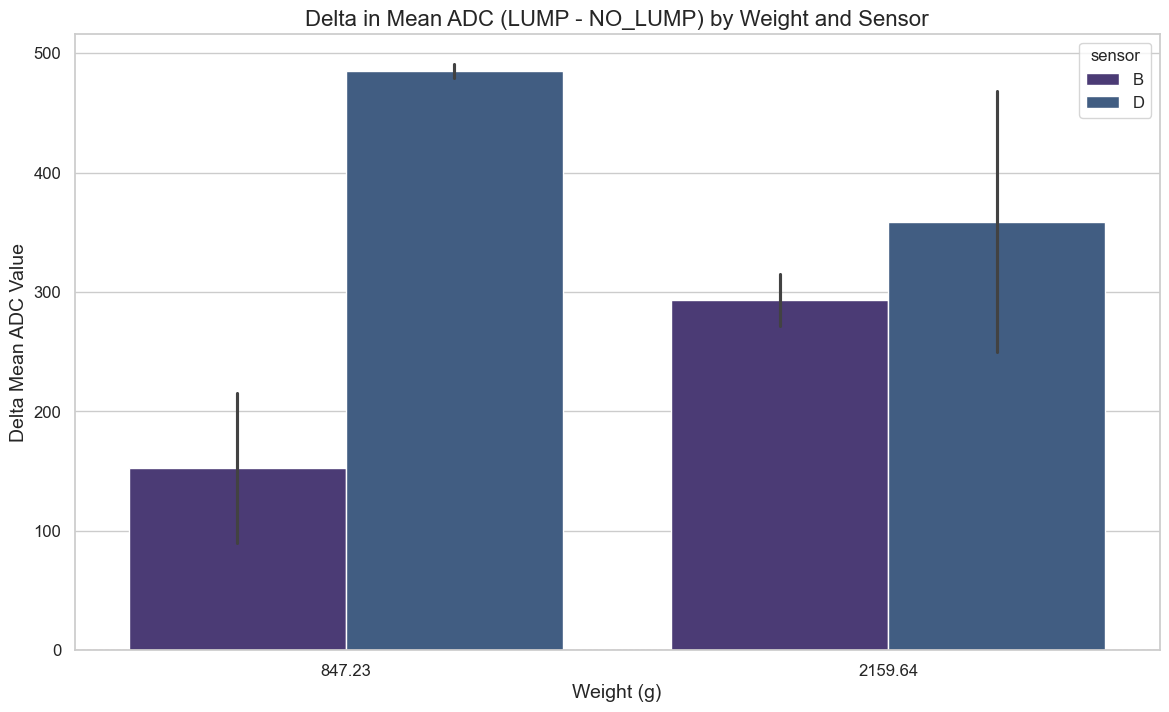

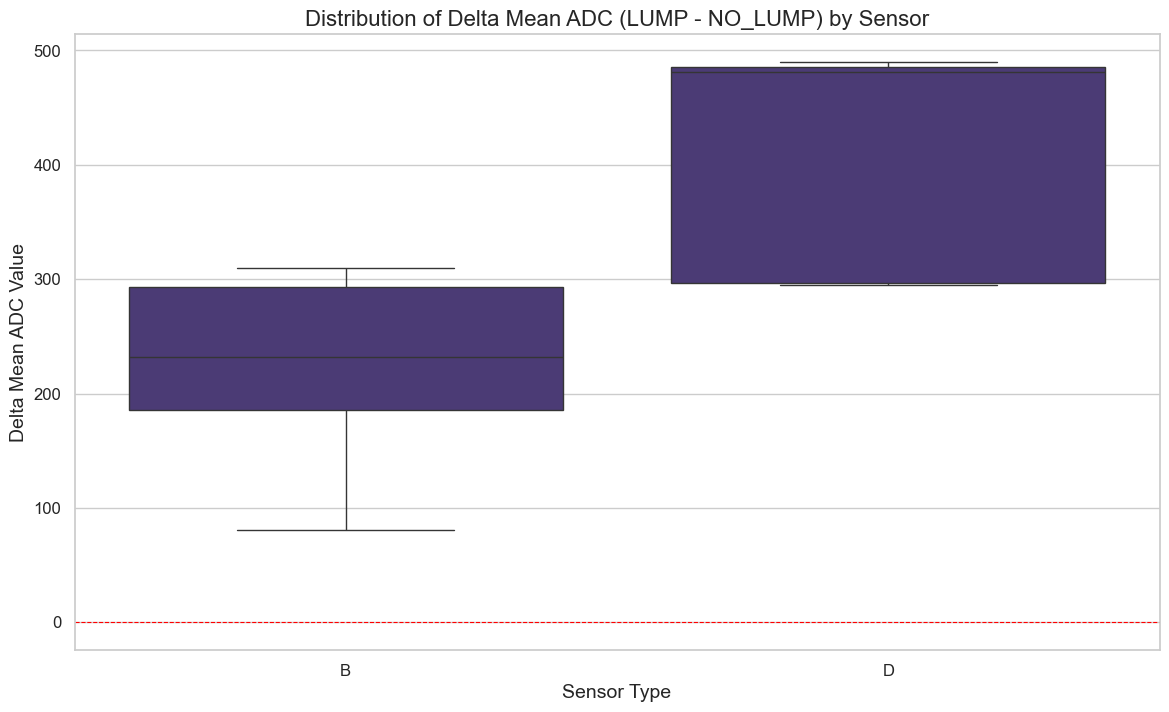

In [16]:
delta_records = []
for (sensor, weight, trial), group in df_summary.groupby(['sensor', 'weight', 'trial']):
    lump_data = group[group['lump_status'] == 'LUMP']
    no_lump_data = group[group['lump_status'] == 'NO_LUMP']

    if not lump_data.empty and not no_lump_data.empty:
        mean_lump = lump_data['mean_adc'].iloc[0]
        mean_no_lump = no_lump_data['mean_adc'].iloc[0]
        delta = mean_lump - mean_no_lump
        delta_records.append({
            'sensor': sensor,
            'weight': weight,
            'trial': trial,
            'delta_mean_adc': delta
        })

df_delta = pd.DataFrame(delta_records)

if not df_delta.empty:
    print("Delta (LUMP - NO_LUMP) Mean ADC Values:")
    print(df_delta.head())

    plt.figure(figsize=(14, 8))
    sns.barplot(x='weight', y='delta_mean_adc', hue='sensor', data=df_delta, ci='sd')
    plt.title('Delta in Mean ADC (LUMP - NO_LUMP) by Weight and Sensor')
    plt.xlabel('Weight (g)')
    plt.ylabel('Delta Mean ADC Value')
    plt.axhline(0, color='red', linestyle='--', linewidth=0.8) # Add a zero line
    plt.show()

    plt.figure(figsize=(14, 8))
    sns.boxplot(x='sensor', y='delta_mean_adc', data=df_delta)
    plt.title('Distribution of Delta Mean ADC (LUMP - NO_LUMP) by Sensor')
    plt.xlabel('Sensor Type')
    plt.ylabel('Delta Mean ADC Value')
    plt.axhline(0, color='red', linestyle='--', linewidth=0.8)
    plt.show()
else:
    print("No sufficient data to calculate LUMP vs NO_LUMP deltas.")


### 3.5 Standard Deviation Analysis

Analyzing the standard deviation helps understand the variability or noise in the sensor readings under different conditions.

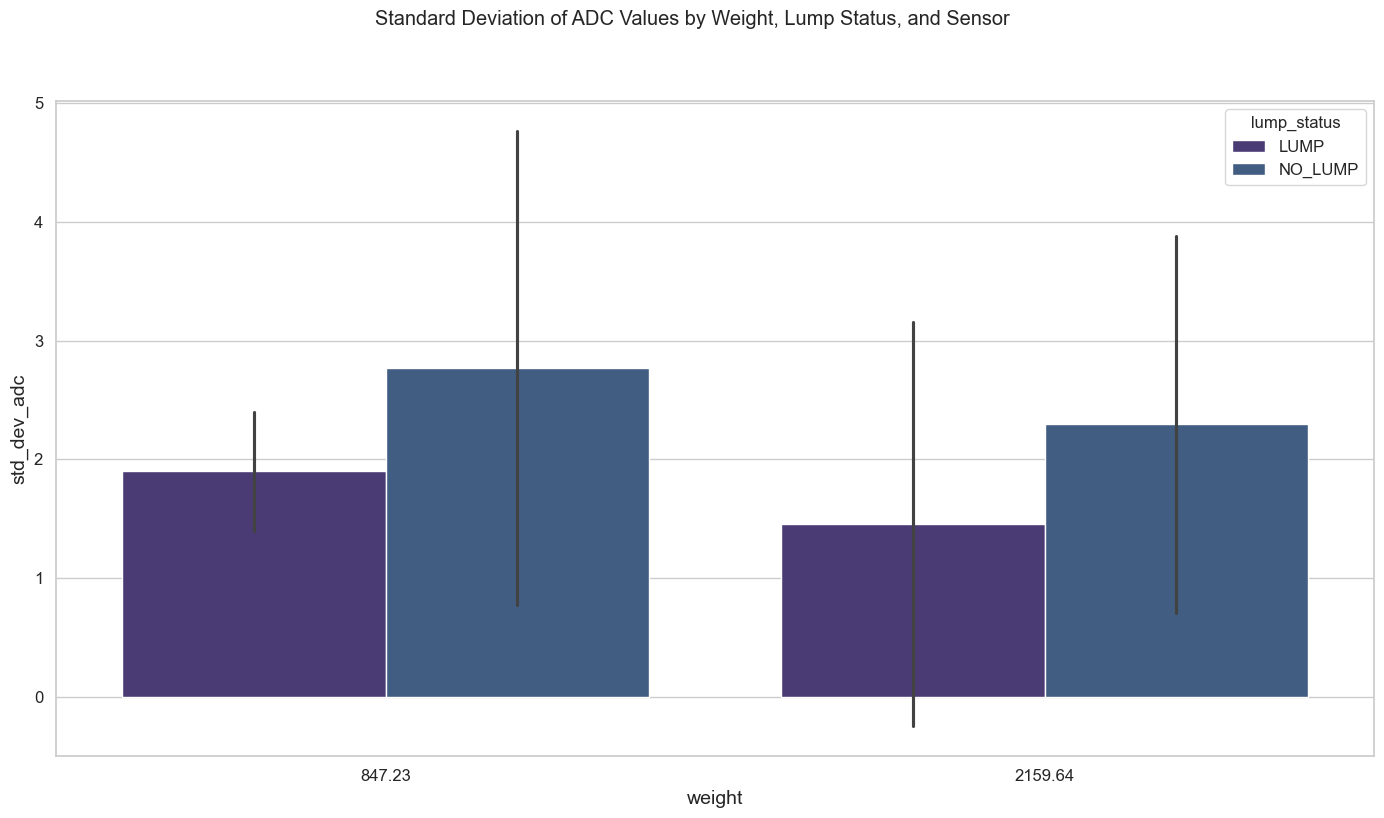

/var/folders/39/vp90gr214c13m_vlt2mvyqz80000gn/T/ipykernel_75585/206893003.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(x='weight', y='std_dev_adc', hue='lump_status', style='sensor', data=df_summary, marker='o', ci='sd')


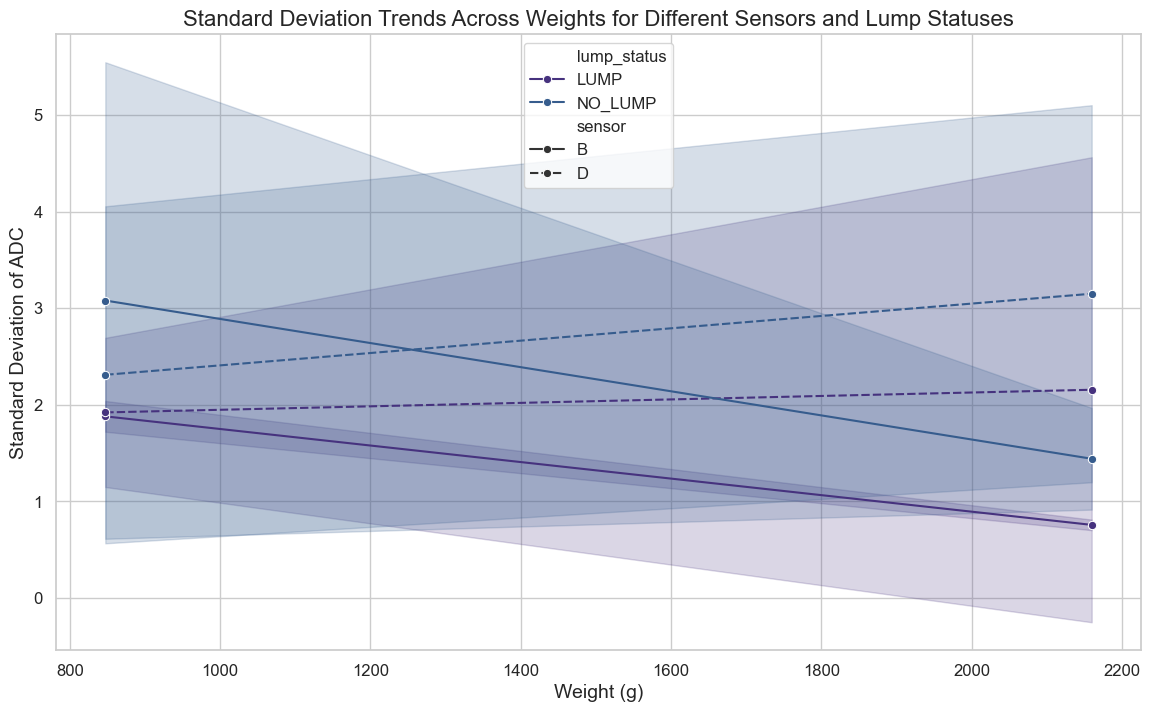

In [20]:
plt.figure(figsize=(14, 8))
sns.barplot(x='weight', y='std_dev_adc', hue='lump_status', data=df_summary, errorbar='sd')
plt.suptitle('Standard Deviation of ADC Values by Weight, Lump Status, and Sensor', y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

plt.figure(figsize=(14, 8))
sns.lineplot(x='weight', y='std_dev_adc', hue='lump_status', style='sensor', data=df_summary, marker='o', ci='sd')
plt.title('Standard Deviation Trends Across Weights for Different Sensors and Lump Statuses')
plt.xlabel('Weight (g)')
plt.ylabel('Standard Deviation of ADC')
plt.show()


## 4. Conclusion and Insights

Based on the statistical analysis and visualizations, we can draw several conclusions about the pressure sensor data:

- **Sensor Response to Weight:** (Summarize findings from plots showing ADC vs. Weight)
  - Both sensors (B and D) generally show an increase/decrease in ADC values with increasing weight, indicating they are responsive to applied pressure.
  - Observe if the relationship is linear or non-linear.

- **Impact of Lump:** (Summarize findings from Delta plots and Lump vs. No Lump comparisons)
  - The 'LUMP' condition generally leads to [higher/lower/different] ADC readings compared to 'NO_LUMP' for the same weight and sensor.
  - The delta plots clearly show the magnitude and direction of this difference, which is critical for understanding localized pressure detection.
  - Note any sensors or weights where the lump effect is more pronounced.

- **Trial Consistency:** (Summarize findings from plots across trials)
  - The consistency of ADC readings across multiple trials for the same conditions indicates the reliability and repeatability of the sensor measurements.
  - Look for significant variations between trials, which might suggest external factors or sensor instability.

- **Sensor Variability (Standard Deviation):** (Summarize findings from Std Dev plots)
  - The standard deviation provides insight into the noise or stability of the sensor readings.
  - Higher standard deviation might indicate more fluctuating readings, potentially due to sensor noise, environmental factors, or the nature of the applied pressure.
  - Compare standard deviations between sensors, weights, and lump statuses.

- **Sensor-Specific Characteristics:** (Summarize differences between Sensor B and D)
  - Sensor B and Sensor D might exhibit different baseline readings, sensitivities, or responses to the lump condition.
  - Highlight any unique characteristics or performance differences between the two sensor types.

This analysis provides a strong foundation for further investigation, such as calibration, anomaly detection, or developing pressure mapping algorithms based on these sensors.

In [5]:
sensors = df_summary['sensor'].unique()
weights = df_summary['weight'].unique()

for sensor in sensors:
    for weight in weights:
        print(f"\n--- ADC Stats for Sensor {sensor}, Weight {weight}g (Averaged Across Trials) ---")
        
        filtered_data = df_summary[
            (df_summary['sensor'] == sensor) &
            (df_summary['weight'] == weight)
        ]
        
        if filtered_data.empty:
            print("No data found for this sensor and weight combination.")
            continue
        
        grouped_by_lump = filtered_data.groupby('lump_status').agg(
            avg_max_adc=('max_adc', 'mean'),
            avg_min_adc=('min_adc', 'mean'),
            mean_adc=('mean_adc', 'mean'),
            std_dev_adc=('std_dev_adc', 'mean')  # average of std dev here
        ).reset_index()
        
        print(grouped_by_lump.to_string(index=False))


--- ADC Stats for Sensor B, Weight 2159.64g (Averaged Across Trials) ---
lump_status  avg_max_adc  avg_min_adc    mean_adc  std_dev_adc
       LUMP  3211.333333  3207.333333 3209.316547     0.757339
    NO_LUMP  2919.000000  2913.333333 2916.103118     1.441695

--- ADC Stats for Sensor B, Weight 847.23g (Averaged Across Trials) ---
lump_status  avg_max_adc  avg_min_adc    mean_adc  std_dev_adc
       LUMP  2867.666667  2858.333333 2863.062350     1.880571
    NO_LUMP  2715.333333  2704.000000 2710.357314     3.079604

--- ADC Stats for Sensor D, Weight 2159.64g (Averaged Across Trials) ---
lump_status  avg_max_adc  avg_min_adc    mean_adc  std_dev_adc
       LUMP  3119.666667       3113.0 3116.494005     2.156018
    NO_LUMP  2763.000000       2753.0 2757.546763     3.149921

--- ADC Stats for Sensor D, Weight 847.23g (Averaged Across Trials) ---
lump_status  avg_max_adc  avg_min_adc    mean_adc  std_dev_adc
       LUMP  2847.666667       2840.0 2844.426859     1.921313
    NO_LUMP  

Text(0.5, 0.98, 'Mean ADC Values by Sensor, Lump, and Wt')

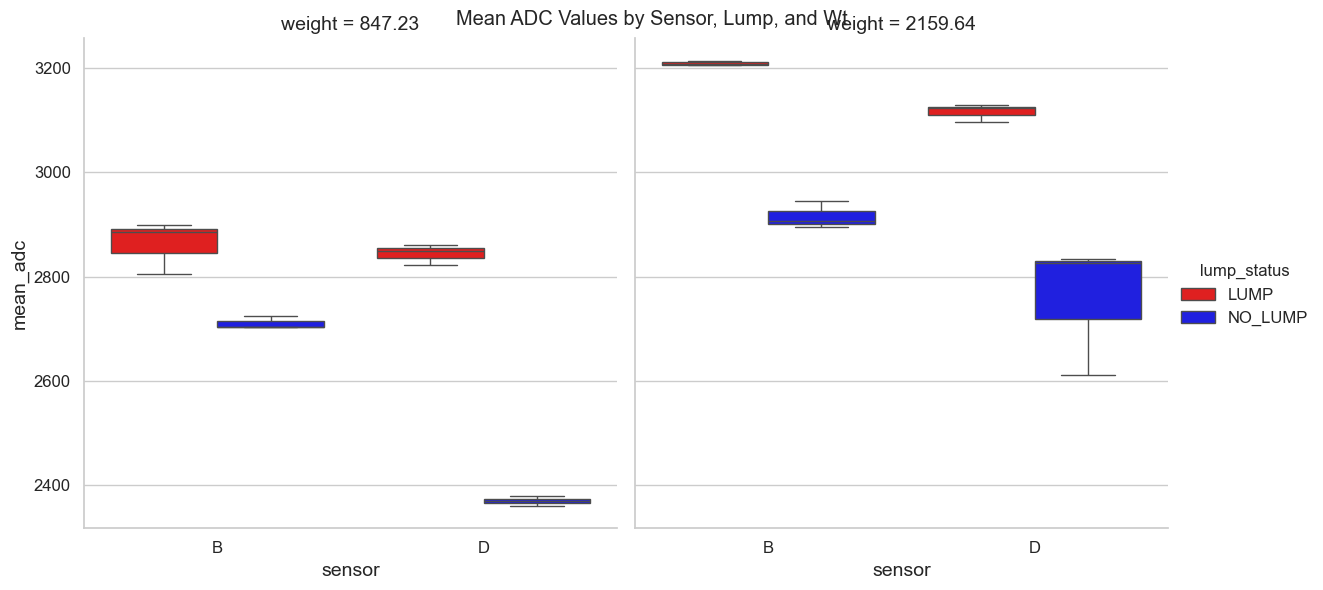

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

palettep = {
    'LUMP': 'red',
    'NO_LUMP': 'blue'
}

g = sns.catplot(
    x='sensor', y='mean_adc',
    hue='lump_status', col='weight',
    data=df_summary,
    kind='box',
    height=6, aspect=1, palette=palettep
)
g.fig.suptitle('Mean ADC Values by Sensor, Lump, and Wt')

/var/folders/39/vp90gr214c13m_vlt2mvyqz80000gn/T/ipykernel_78279/3788115610.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/39/vp90gr214c13m_vlt2mvyqz80000gn/T/ipykernel_78279/3788115610.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/39/vp90gr214c13m_vlt2mvyqz80000gn/T/ipykernel_78279/3788115610.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/39/vp90gr214c13m_vlt2mvyqz80000gn/T/ipykernel_78279/3788115610.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated a

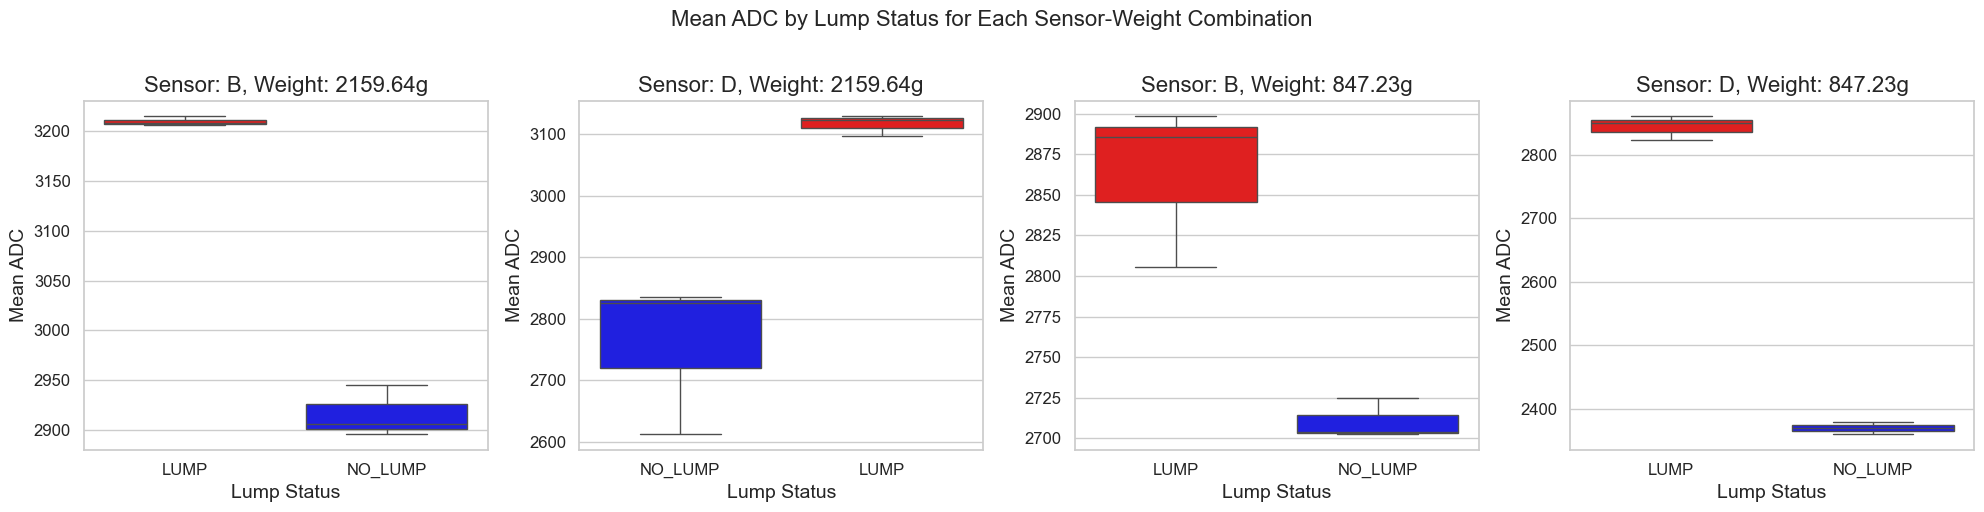

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import math

palettep = {
    'LUMP': 'red',
    'NO_LUMP': 'blue'
}

sensors = df_summary['sensor'].unique()
weights = df_summary['weight'].unique()

# Total number of plots
total_plots = len(sensors) * len(weights)

# Determine subplot grid size (try square-ish)
cols = min(4, total_plots)  # max 4 plots per row to keep it readable
rows = math.ceil(total_plots / cols)

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows), squeeze=False)

plot_idx = 0
for weight in weights:
    for sensor in sensors:
        row = plot_idx // cols
        col = plot_idx % cols
        ax = axes[row, col]

        # Filter data for this combination
        data_subset = df_summary[(df_summary['weight'] == weight) & (df_summary['sensor'] == sensor)]
        
        if data_subset.empty:
            ax.text(0.5, 0.5, 'No data', ha='center', va='center')
            ax.axis('off')
        else:
            sns.boxplot(
                x='lump_status',
                y='mean_adc',
                data=data_subset,
                palette=palettep,
                ax=ax
            )
            ax.set_title(f'Sensor: {sensor}, Weight: {weight}g')
            ax.set_xlabel('Lump Status')
            ax.set_ylabel('Mean ADC')

        plot_idx += 1

# Remove any unused subplots
for i in range(plot_idx, rows * cols):
    fig.delaxes(axes[i // cols, i % cols])

fig.suptitle('Mean ADC by Lump Status for Each Sensor-Weight Combination', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()
